# NER: Flair and BERT evaluation using softmax probabilities

**Contents:**

- Predictions

- Timings

- Confusion matrices, precision, recall, f1-scores

- Classification probabilities and analysis of chosen sentences

- The words that are categorised as MISC

- Calibration

In [2]:
# general
import numpy as np
import time
import torch
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.calibration import calibration_curve

# models
from danlp.models import load_bert_ner_model, load_flair_ner_model

# dataset
from danlp.datasets import DDT

# utils
from flair.data import Sentence, Token

In [3]:
# load models
bert = load_bert_ner_model()
flair = load_flair_ner_model()

# get data (splitted into a training set, a validation set, and a test set)
ddt = DDT()
train, valid, test = ddt.load_as_simple_ner(True)

2021-01-19 13:17:59,945 loading file /Users/jorgentaule/.danlp/flair.ner.pt


In [4]:
# divide the observations and the targets of the testset into new variables
sentences, categories = test

### Get predictions

In [5]:
def get_bert_predictions():
    start = time.time()
    
    predictions_list = []
    output_probabilities = []
    
    for sentence in sentences:
        tokens = []
        tokens_mask = [1]
        for word in sentence:
            word_tokens = bert.tokenizer.tokenize(word)
            tokens.extend(word_tokens)
            tokens_mask.extend([1]+[0]*(len(word_tokens)-1))
        tokens_mask.extend([1])

        inputs = bert.tokenizer.encode(tokens, return_tensors="pt")
        
        outputs = bert.model(inputs)[0]
        
        softmax = torch.nn.Softmax(dim=1)
        outputs = torch.Tensor(softmax(outputs[0])).view(outputs.shape)
        
        predictions = torch.argmax(outputs, dim=2)

        # Mask the predictions so we only get the labels for the
        # pre-tokenized text
        predictions = [prediction for prediction, mask in zip(predictions[0].tolist(), tokens_mask) if mask]
        outputs = [[out for out, mask in zip(outputs[0].tolist(), tokens_mask) if mask]]
        outputs = torch.Tensor(outputs)
        outputs = outputs[0][1:-1]
        predictions = predictions[1:-1]  # Remove special tokens
        
        output_probabilities.append(outputs)

        # Map prediction ids to labels
        predictions = [bert.label_list[label] for label in predictions]
        
        predictions_list.append(predictions)
    
    time_spent = time.time()-start
    
    return predictions_list, time_spent, output_probabilities

In [6]:
bert_preds, bert_time_spent, output_probabilities = get_bert_predictions()

In [7]:
def get_flair_predictions():
    start = time.time()
    
    predictions = []
    
    flair_sentences = []
    for sentence in sentences:
        flair_sentence = Sentence()
        for token in sentence:
            flair_sentence.add_token(Token(token))
        flair_sentences.append(flair_sentence)
    flair.predict(flair_sentences, all_tag_prob=True)
    
    for s in flair_sentences:
        predicted_categories = []
        for t in s:
            predicted_categories.append(t.tags['ner'].value)
        predictions.append(predicted_categories)
    
    time_spent = time.time()-start
    
    return predictions, time_spent, flair_sentences

In [8]:
flair_preds, flair_time_spent, flair_sentences = get_flair_predictions()

/Users/jorgentaule/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/flair/embeddings.py:355: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  word_embedding, device=flair.device, dtype=torch.float


In [9]:
print(flair_time_spent)

31.59415578842163


In [10]:
from numpy import savetxt, loadtxt

savetxt('flair_times.csv', flair_times, delimiter=',')
savetxt('bert_times.csv', bert_times, delimiter=',')

#flair_times = loadtxt('flair_times.csv', delimiter=',')
#bert_times = loadtxt('bert_times.csv', delimiter=',')

NameError: name 'flair_times' is not defined

### Timings

In [ ]:
bert_times, np.mean(bert_times)

In [ ]:
flair_times, np.mean(flair_times)

In [ ]:
x = [0, 1]
plt.bar(x[0], height=np.mean(bert_times)/len(sentences))
plt.bar(x[1], height=np.mean(flair_times)/len(sentences))
plt.xticks(x, ['bert', 'flair'])
plt.ylabel('seconds per sentence')
plt.show()
bert_time_spent/flair_time_spent
print('The FlairNer model is {:.3} times faster then BertNer.'.format(np.mean(bert_times)/np.mean(flair_times)))

## Confusion matrices, precision, recall, f1-scores

Precision: how many of the predicted instances of a class were actually correct?

Recall: how many instances in a class were identified by the model?

f1: gives a more realitic picture of a balance between precision and recall when there is a large class imbalance.

In [11]:
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes
    source: https://gist.github.com/zachguo/10296432"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    
    # Begin CHANGES
    fst_empty_cell = (columnwidth-3)//2 * " " + "t/p" + (columnwidth-3)//2 * " "
    
    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES
    
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
        
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.0f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [12]:
flair_preds_flattened = [item for sublist in flair_preds for item in sublist]
bert_preds_flattened = [item for sublist in bert_preds for item in sublist]
categories_flattened = [item for sublist in categories for item in sublist]

In [13]:
bert_cm = confusion_matrix(categories_flattened, bert_preds_flattened, labels=bert.label_list)
flair_cm = confusion_matrix(categories_flattened, flair_preds_flattened, labels=bert.label_list)

In [14]:
categories_nomisc_flattened = deepcopy(categories_flattened)
labels_nomisc = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

for i, token in enumerate(categories_nomisc_flattened):
    if token=='B-MISC' or token=='I-MISC':
        categories_nomisc_flattened[i]='O'
        
bert_cm_nomisc = confusion_matrix(categories_nomisc_flattened, bert_preds_flattened, labels=labels_nomisc)
flair_cm_nomisc = confusion_matrix(categories_nomisc_flattened, flair_preds_flattened, labels=labels_nomisc)

In [15]:
categories_nomisc_noIB_flattened = deepcopy(categories_nomisc_flattened)
bert_preds_noIB_flattened = deepcopy(bert_preds_flattened)
flair_preds_noIB_flattened = deepcopy(flair_preds_flattened)

for i, token in enumerate(bert_preds_noIB_flattened):
    if token!='O':
        bert_preds_noIB_flattened[i]=token[2:]

for i, token in enumerate(flair_preds_noIB_flattened):
    if token!='O':
        flair_preds_noIB_flattened[i]=token[2:]
        
for i, token in enumerate(categories_nomisc_noIB_flattened):
    if token!='O':
        categories_nomisc_noIB_flattened[i]=token[2:]

labels_noIB = ['O', 'PER', 'ORG', 'LOC']

bert_cm_noIB = confusion_matrix(
    categories_nomisc_noIB_flattened, bert_preds_noIB_flattened, labels=labels_noIB)
flair_cm_noIB = confusion_matrix(
    categories_nomisc_noIB_flattened, flair_preds_noIB_flattened, labels=labels_noIB)

#### BERT confusion matrix with MISC

In [16]:
print_cm(bert_cm, labels=bert.label_list)

      t/p       O B-MISC I-MISC  B-PER  I-PER  B-ORG  I-ORG  B-LOC  I-LOC 
         O   9214      0      0      1      0      4      1      2      2 
    B-MISC    111      0      0      0      0     10      0      0      0 
    I-MISC     36      0      0      1      0      0      1      0      0 
     B-PER     10      0      0    168      0      1      0      1      0 
     I-PER      0      0      0      0    138      0      0      0      0 
     B-ORG     25      0      0     11      0    106      0     19      0 
     I-ORG      8      0      0      0      3      1     33      0     15 
     B-LOC      9      0      0      0      0      1      0     86      0 
     I-LOC      1      0      0      0      0      0      0      0      4 


#### BERT confusion matrix without MISC

In [17]:
print_cm(bert_cm_nomisc, labels=labels_nomisc)

     t/p      O B-PER I-PER B-ORG I-ORG B-LOC I-LOC 
        O  9361     2     0    14     2     2     2 
    B-PER    10   168     0     1     0     1     0 
    I-PER     0     0   138     0     0     0     0 
    B-ORG    25    11     0   106     0    19     0 
    I-ORG     8     0     3     1    33     0    15 
    B-LOC     9     0     0     1     0    86     0 
    I-LOC     1     0     0     0     0     0     4 


#### BERT precision, recall, f1-score without MISC

In [18]:
print(classification_report(categories_nomisc_flattened, bert_preds_flattened, labels=labels_nomisc))

              precision    recall  f1-score   support

           O       0.99      1.00      1.00      9383
       B-PER       0.93      0.93      0.93       180
       I-PER       0.98      1.00      0.99       138
       B-ORG       0.86      0.66      0.75       161
       I-ORG       0.94      0.55      0.69        60
       B-LOC       0.80      0.90      0.84        96
       I-LOC       0.19      0.80      0.31         5

    accuracy                           0.99     10023
   macro avg       0.81      0.83      0.79     10023
weighted avg       0.99      0.99      0.99     10023



#### BERT confusion matrix without MISC, B-, I-

In [19]:
print_cm(bert_cm_noIB, labels=labels_noIB)

     t/p      O   PER   ORG   LOC 
        O  9361     2    16     4 
      PER    10   306     1     1 
      ORG    33    14   140    34 
      LOC    10     0     1    90 


#### BERT precision, recall, f1-score without MISC, B-, I-

In [20]:
print(classification_report(
    categories_nomisc_noIB_flattened, bert_preds_noIB_flattened, labels=labels_noIB))

              precision    recall  f1-score   support

           O       0.99      1.00      1.00      9383
         PER       0.95      0.96      0.96       318
         ORG       0.89      0.63      0.74       221
         LOC       0.70      0.89      0.78       101

    accuracy                           0.99     10023
   macro avg       0.88      0.87      0.87     10023
weighted avg       0.99      0.99      0.99     10023



#### FLAIR confusion matrix with MISC

In [21]:
print_cm(flair_cm, labels=bert.label_list)

      t/p       O B-MISC I-MISC  B-PER  I-PER  B-ORG  I-ORG  B-LOC  I-LOC 
         O   9222      0      0      0      0      0      2      0      0 
    B-MISC    112      0      0      0      0      5      0      4      0 
    I-MISC     37      0      0      1      0      0      0      0      0 
     B-PER      8      0      0    170      0      1      0      1      0 
     I-PER      0      0      0      0    138      0      0      0      0 
     B-ORG     59      0      0     13      0     81      0      8      0 
     I-ORG     12      0      0      0      5      1     42      0      0 
     B-LOC     10      0      0      1      0      2      1     82      0 
     I-LOC      2      0      0      0      0      0      1      0      2 


#### FLAIR confusion matrix without MISC

In [22]:
print_cm(flair_cm_nomisc, labels=labels_nomisc)

     t/p      O B-PER I-PER B-ORG I-ORG B-LOC I-LOC 
        O  9371     1     0     5     2     4     0 
    B-PER     8   170     0     1     0     1     0 
    I-PER     0     0   138     0     0     0     0 
    B-ORG    59    13     0    81     0     8     0 
    I-ORG    12     0     5     1    42     0     0 
    B-LOC    10     1     0     2     1    82     0 
    I-LOC     2     0     0     0     1     0     2 


#### FLAIR precision, recall, f1-score without MISC

In [23]:
print(classification_report(categories_nomisc_flattened, flair_preds_flattened, labels=labels_nomisc))

              precision    recall  f1-score   support

           O       0.99      1.00      0.99      9383
       B-PER       0.92      0.94      0.93       180
       I-PER       0.97      1.00      0.98       138
       B-ORG       0.90      0.50      0.65       161
       I-ORG       0.91      0.70      0.79        60
       B-LOC       0.86      0.85      0.86        96
       I-LOC       1.00      0.40      0.57         5

    accuracy                           0.99     10023
   macro avg       0.94      0.77      0.83     10023
weighted avg       0.99      0.99      0.98     10023



#### FLAIR confusion matrix without MISC, B-, I-

In [24]:
print_cm(flair_cm_noIB, labels=labels_noIB)

     t/p      O   PER   ORG   LOC 
        O  9371     1     7     4 
      PER     8   308     1     1 
      ORG    71    18   124     8 
      LOC    12     1     4    84 


#### FLAIR precision, recall, f1-score without MISC, B-, I-

In [25]:
print(classification_report(
    categories_nomisc_noIB_flattened, flair_preds_noIB_flattened, labels=labels_noIB))

              precision    recall  f1-score   support

           O       0.99      1.00      0.99      9383
         PER       0.94      0.97      0.95       318
         ORG       0.91      0.56      0.69       221
         LOC       0.87      0.83      0.85       101

    accuracy                           0.99     10023
   macro avg       0.93      0.84      0.87     10023
weighted avg       0.99      0.99      0.99     10023



In [249]:
sentences_flattened = [item for sublist in sentences for item in sublist]

## Classification probabilities

In [304]:
def sentence_prediction_analysis(sentence, targets, include_O=False, calibrated_model_info=None):
    
    print('Sentence:', sentence)
    print('Targets:', targets)
    
    ### bert ###
    
    tokens = []
    tokens_mask = [1]
    for word in sentence:
        word_tokens = bert.tokenizer.tokenize(word)
        tokens.extend(word_tokens)
        tokens_mask.extend([1]+[0]*(len(word_tokens)-1))
    tokens_mask.extend([1])

    inputs = bert.tokenizer.encode(tokens, return_tensors="pt")
    
    outputs = bert.model(inputs)[0]
    outputs_non_softmax = outputs
    softmax = torch.nn.Softmax(dim=1)
    bert_outputs = torch.Tensor(softmax(outputs[0])).view(outputs.shape)
    predictions_probs = torch.max(bert_outputs, dim=2).values.detach()
    predictions = torch.argmax(outputs, dim=2)
    
    predictions = [prediction for prediction, mask in zip(predictions[0].tolist(), tokens_mask) if mask]
    predictions_probs = [prob for prob, mask in zip(predictions_probs[0].tolist(), tokens_mask) if mask]
    outputs_non_softmax = [[out for out, mask in zip(outputs_non_softmax[0].tolist(), tokens_mask) if mask]]
    outputs_non_softmax = torch.Tensor(outputs_non_softmax)
    
    # bert plot - compare labels
    bert_labels = []
    for i in range(len(sentence)):
        bert_labels.append(
            targets[i]+' '+sentence[i]+', pred: '+[bert.label_list[label] for label in predictions[1:-1]][i])
    
    plt.figure(figsize=(16,8))
    for i in range(len(targets)):
        if targets[i]!='O' or include_O:
            plt.plot(bert.label_list, outputs_non_softmax[0][i+1], label=bert_labels[i])
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title('Bert - score given label for each word in the sentence')
    plt.xlabel('possible labels')
    plt.show()
    
    predictions = predictions[1:-1]
    bert_predictions_probs = predictions_probs[1:-1]
    bert_predictions = [bert.label_list[label] for label in predictions]
    
    # bert plot - compare words in the sentence
    plt.figure(figsize=(16,4))
    plt.plot(bert_predictions_probs)
    plt.xticks(np.arange(len(targets)), bert_labels)
    plt.xticks(rotation=90)
    plt.title('Bert - confidence in prediction on a scale 0-1')
    plt.xlabel('sentence targets and predictions')
    plt.show()
    
    ### flair ###
    
    flair_sentence = Sentence()
    for token in sentence:
        flair_sentence.add_token(Token(token))
    flair.predict([flair_sentence], all_tag_prob=True)
    
    flair_labels = flair.tag_dictionary.get_items()
    flair_predictions_probs = []
    for word in range(len(flair_sentence)):
        probs = []
        for tok in flair_sentence.tokens[word].tags_proba_dist['ner']:
            probs.append(tok.score)
        flair_predictions_probs.append(probs)
    
    flair_predictions = []
    for t in flair_sentence:
        flair_predictions.append(t.tags['ner'].value)
    
    flair_description_labels = []
    for i in range(len(sentence)):
        flair_description_labels.append(
            targets[i]+' '+sentence[i]+', pred: '+flair_predictions[i])
    
    # flair plot - compare labels
    plt.figure(figsize=(16,8))
    for i in range(len(targets)):
        if targets[i]!='O' or include_O:
            plt.plot(flair_labels, flair_predictions_probs[i], label=flair_description_labels[i])
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title('flair - score given label for each word in the sentence')
    plt.xlabel('possible labels')
    plt.show()
    
    # flair plot - compare words in the sentence
    plt.figure(figsize=(16,4))
    plt.plot(np.max(flair_predictions_probs, axis=1))
    plt.xticks(np.arange(len(targets)), flair_description_labels)
    plt.xticks(rotation=90)
    plt.title('flair - confidence in prediction on a scale 0-1')
    plt.xlabel('sentence targets and predictions')
    plt.show()
    
    if calibrated_model_info is not None:
        index = calibrated_model_info['index']
        out_probs = calibrated_model_info['output_probabilities']
        calibrated_flair_predictions = calibrated_model_info['predictions']
        
        calibrated_flair_description_labels = []
        for i in range(len(sentence)):
            calibrated_flair_description_labels.append(
                targets[i]+' '+sentence[i]+', pred: '+calibrated_flair_predictions[i])
        
        # calibrated flair plot - compare labels
        plt.figure(figsize=(16,8))
        for i in range(len(targets)):
            if targets[i]!='O' or include_O:
                plt.plot(flair_labels, out_probs[i], 
                         label=calibrated_flair_description_labels[i])
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
        plt.title('calibrated flair - score given label for each word in the sentence')
        plt.xlabel('possible labels')
        plt.show()
        
        # flair plot - compare words in the sentence
        plt.figure(figsize=(16,4))
        plt.plot(np.max(out_probs, axis=1))
        plt.xticks(np.arange(len(targets)), calibrated_flair_description_labels)
        plt.xticks(rotation=90)
        plt.title('calibrated flair - confidence in prediction on a scale 0-1')
        plt.xlabel('sentence targets and predictions')
        plt.show()
        
        
        
    
    print('Sentence:', sentence)
    print('Targets:', targets)
    print('Bert predictions:', bert_predictions)
    print('Flair predictions:', flair_predictions)
    if calibrated_model_info is not None:
        print('Calibrated flair predictions:', calibrated_flair_predictions)
    
    bert_info = {
        'predictions': bert_predictions, 
        'predictions_probs': bert_predictions_probs, 
        'outputs': bert_outputs
    }
    
    flair_info = {
        'predictions': flair_predictions,
        'predictions_probs': np.max(flair_predictions_probs, axis=1),
        'outputs': flair_predictions_probs,
        'sentences': flair_sentences
    }
    
    return bert_info, flair_info

**Set index number to choose sentence of which you want to output predictions and predictions analysis.**

A summary of some of the observations below:

The model
- is certain in all cases that a given word does not belong to the MISC category.
- is able to infer where there probably has been an annotation conflict
- many of the mistakes are debatable
- the hypothesising of the model makes sense in all observed cases

**Observations on the sentences given index**

1: missing two MISCs, less confident on 'O' when actual is MISC

4: flair shows insecurity on B-MISC

5: wrong predictions of one entity, but B-ORG is on a weak second place.
flair predicts correctly here.

6: missing MISC, predicts 'O', second place is B-ORG. Gets less confident on the word in question.
flair has the same reaction as BERT.

11: Misses both ORG and MISC, but suspects ORG.
flair does the same.

15: "ligebehandlingsnævn" is not categorised as an ORG in the targets (?)
flair misses B-ORG Socialdemokratiet.

23: model realizes that there is something different with the categorized word, but predicts 'O' instead of MISC

26: Makes mistake on ORG, but is less sure about it. Misses a MISC, but is also less sure here.
flair is not that sure, but predicts correctly where bert does not, ignoring misc.

32: The prediction is more accurate than the labelling(?)
flair: same comment.
For difference between "Skjerns menighedsråd" og "Skjern Menighedsråd", set third to True.

37: Interesting case: The model is almost as sure of it being B-ORG as 'O'. (62 % versus 36 %)
flair reacts the same way as BERT.

39: Everything correct, model points to "forsvarsministeren" to maybe be B-PER or B-ORG.
flair: same.

42: Everything correct, model points to "sikkerhedsutvalget" to maybe be B-ORG.
flair: same.

43: Everything correct, model points to "efterretningsvæsenet" to maybe be B-ORG.
flair: same.

46: Predicts "sikkerhedsutvalg" to be B-ORG.
flair does not make that mistake, but also points to this. flair also thinks it's likely that Statsministeren is LOC.

47: see 15. "Det udenrigspolitiske nævn" is predikted as 'O', but has targets 'B-ORG', 'I-ORG'. 
The model notices that something is special with the word 'nævn'. The model predicts 'FET' wrongly, but 
notices that something is different.
flair does that same mistakes, but is more aware of the FET word.

51: hypothesized 'slagteriet' to be 'B-ORG', but target is 'O'.
flair does not make this mistake here.

55: flair slightly misses ALDI as ORG. Bert does correct predictions.

58: Model misses MISC, but notices that something is special with the entity.
flair categorizes the MISC as ORG.

61: Bert correct. Flair slightly misses FDB as an organisation.

63: 'Brugser' og 'Super-Brugser' is categorised as ORG (predicted as 'O'), but refers to stores.
flair does the same as BERT.

65: Both misses out on 'Super-Brugser' as an ORG, but flair is again a lot closer to predicting ORG than BERT.

66: Both misses "Brugser" as an ORG. flair is more calibrated.

71: The model correctly classifies 'Super-Brugsen' as an ORG. See 63.
flair: barely misses SuperBrugsen as an ORG.

72: Flair misses "Nettos" as an ORG, but the O prediction is not that supported.

76: Makes mistake, but this is also the prediction that the model is the most insecure about.
flair does same mistake, but is a lot less sure about its choice.

81: All B-MISC in the targets are predicted as B-ORG. (Football games probably)
flair has difficulties: doesnt know whether to categorise the matches as LOC or ORG, mostly to LOC, and misses one.

82: All B-MISC in the targets are predicted as B-ORG. (Football games probably)
flair is insecure about the MISC predictions.

86: Bert Model misses several MISC. "Europa" and "Cup" is categorised as MISCs in target set, but says "Europa" is O and second an ORG, while flair says it is a LOC.

87: Bert Misses the MISC 'Superligaen'. flair misses "Divisjonsforeningen", but has 20 % that it could be an ORG.

93: Bert Misses 'TV-byen'. 'TV- og radiostationen' is categorised as 'O'.
flair does the same mistake, but is close to not doing it.

97: Bert misses several MISC. Both models infer that something is different with the words, but flair is a lot closer.

99: Misses MISC.

Sentence: ['En', 'rystet', 'journalist', 'fra', 'avisen', 'Respublica', 'i', 'Litauen', 'fortalte', ',', 'at', 'sovjetiske', 'soldater', 'efter', 'massakren', 'havde', 'forsøgt', 'at', 'klæde', 'civile', 'dødsofre', 'i', 'militært', 'tøj', 'for', 'at', 'få', 'dem', 'til', 'at', 'se', 'ud', 'som', 'dræbte', 'soldater', '.']
Targets: ['O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'B-LOC', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


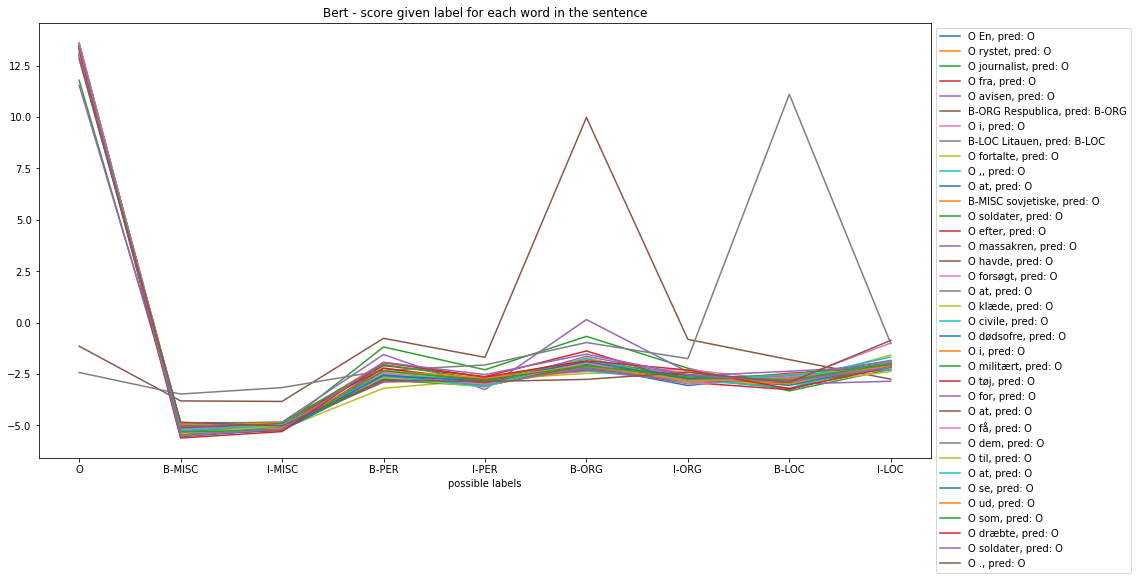

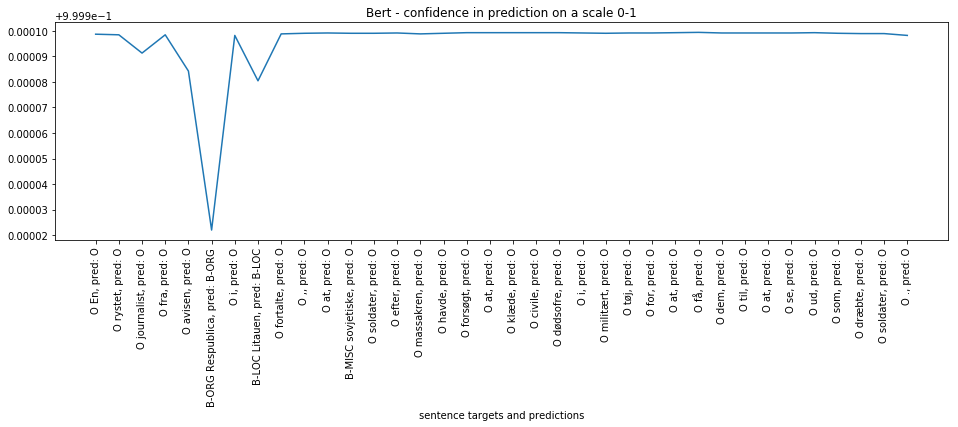

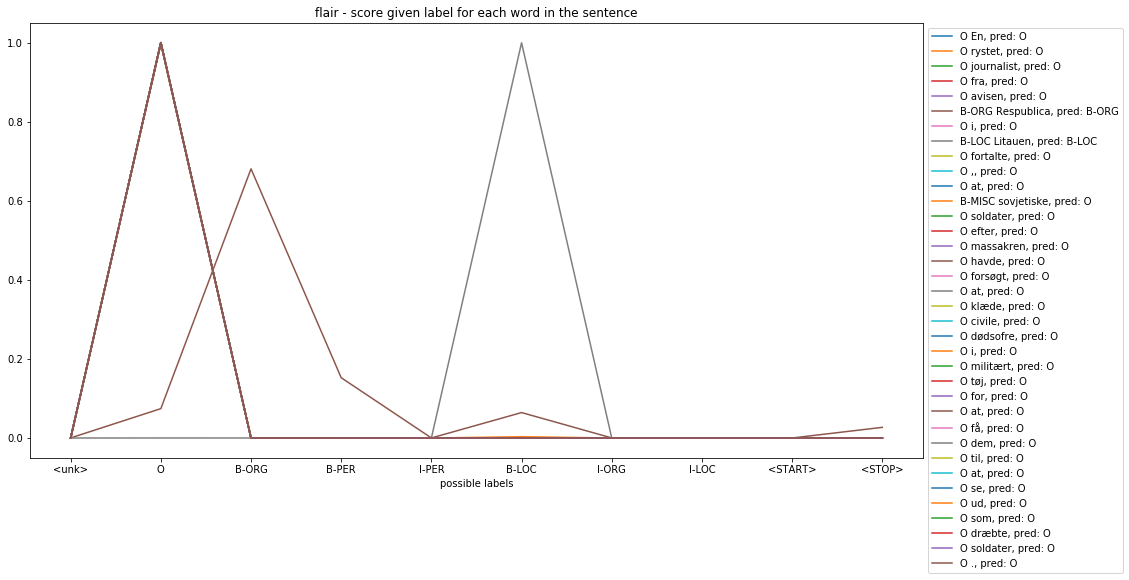

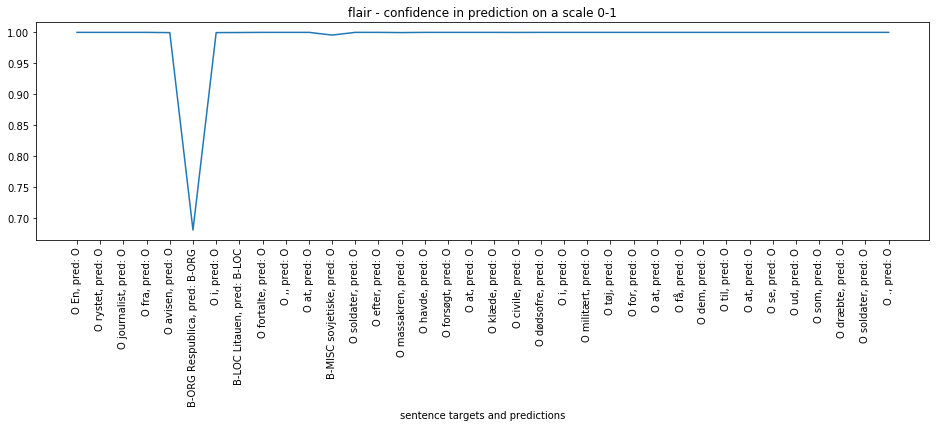

Sentence: ['En', 'rystet', 'journalist', 'fra', 'avisen', 'Respublica', 'i', 'Litauen', 'fortalte', ',', 'at', 'sovjetiske', 'soldater', 'efter', 'massakren', 'havde', 'forsøgt', 'at', 'klæde', 'civile', 'dødsofre', 'i', 'militært', 'tøj', 'for', 'at', 'få', 'dem', 'til', 'at', 'se', 'ud', 'som', 'dræbte', 'soldater', '.']
Targets: ['O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'B-LOC', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Bert predictions: ['O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Flair predictions: ['O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [27]:
index = 99
# obs: 
# 1, 4, 5, 6, 11, 15, 23, 26, 32, 37, 39, 42, 43, 46, 47, 
# 51, 55, 58, 63, 65, 66, 71, 72, 76, 81, 82, 86, 87, 93, 97, 99

bert_info, flair_info = sentence_prediction_analysis(sentences[index], categories[index], True)

## The words that are categorised as MISC

'FDBchefen' is MISC, but 'Statsministeren' is O.

MISC seems random and not very informative and well-defined. Mostly it's adjectives 
saying which country or political party someoneis from.

'tyskerne' is MISC, but 'Brugser' is ORG. Why not PER for 'tyskerne' or MISC for 'Brugser'?

From danlp paper: "This seems to be mainly due to languages, nationalities and adjectives referring, e.g., to nations not being annotated as MISC. Examples are dansk, dansker, europæiske (Danish, Dane, European). In Danish, opposed to in English, such words should not be capitalized and are thus easier to miss by annotators."

In [28]:
for i, sentence in enumerate(categories):
    for j, token in enumerate(sentence):
        if token[2:]=='MISC':
            print(token, sentences[i][j])

B-MISC russiske
B-MISC demokrati
B-MISC diktatur
B-MISC demokratiske
B-MISC demokrati
B-MISC diktatoriske
B-MISC jugoslavisk
B-MISC social-grundtvigianerne
B-MISC indremissionske
B-MISC grundtvigianske-socialdemokratiske
B-MISC danskeres
B-MISC FDBchefen
B-MISC Ikast-Lyngby
B-MISC B-1903-Silkeborg
B-MISC AaB-Vejle
B-MISC FremOB
B-MISC Lyngby-Brøndby
B-MISC Silkeborg-AGF
B-MISC Vejle-Ikast
B-MISC Frem-B
I-MISC 1903
B-MISC AaB-OB
B-MISC DM-guldet
B-MISC Europa
I-MISC Cup
B-MISC Superligaen
B-MISC litauer
B-MISC spanske
B-MISC Sovjet-soldater
B-MISC litauer
B-MISC sovjetiske
B-MISC israelske
B-MISC CNN-journalisterne
B-MISC dansk
B-MISC Brøndby'ere
B-MISC Superliga-finalen
B-MISC Pedal-Ove-sagen
B-MISC The
I-MISC Healer
B-MISC Grammy
B-MISC The
I-MISC Healer
B-MISC 40'erne
B-MISC Dansk
B-MISC danskere
B-MISC Røde-Kro-løjer
B-MISC DANSKE
B-MISC AIDS
B-MISC Hof
B-MISC Tuborg
B-MISC borgerlige
B-MISC socialdemokratiske
B-MISC borgerlige
B-MISC borgerlig
B-MISC Ariostea-mandskabet
B-MISC Orie

## Calibration

In [29]:
def bin_total(y_true, y_prob, n_bins):
    '''Computes the total amount of samples in each bin in the calibration plot
    Source: https://changhsinlee.com/python-calibration-plot/'''
    bins = np.linspace(0., 1. + 1e-8, n_bins + 1)

    # In sklearn.calibration.calibration_curve,
    # the last value in the array is always 0.
    binids = np.digitize(y_prob, bins) - 1

    return np.bincount(binids, minlength=len(bins))

### BERT

In [30]:
#bert_preds, _, output_probabilities = get_bert_predictions()
output_probabilities = torch.cat(tuple(output_probabilities), 0)

Percent of probability for O in range 0.01 to 0.99 is 0.339 %.
Amount of samples in each bin for O: [ 606    1    3    4 9409    0]
Percent of probability for B-PER in range 0.01 to 0.99 is 0.239 %.
Amount of samples in each bin for B-PER: [9839    1    2    2  179    0]
Percent of probability for I-PER in range 0.01 to 0.99 is 0.02 %.
Amount of samples in each bin for I-PER: [9881    1    0    0  141    0]
Percent of probability for B-ORG in range 0.01 to 0.99 is 0.439 %.
Amount of samples in each bin for B-ORG: [9894    6    4    1  118    0]
Percent of probability for I-ORG in range 0.01 to 0.99 is 0.0798 %.
Amount of samples in each bin for I-ORG: [9988    0    1    1   33    0]
Percent of probability for B-LOC in range 0.01 to 0.99 is 0.13 %.
Amount of samples in each bin for B-LOC: [9914    0    1    0  108    0]
Percent of probability for I-LOC in range 0.01 to 0.99 is 0.0299 %.
Amount of samples in each bin for I-LOC: [10002     0     0     0    21     0]


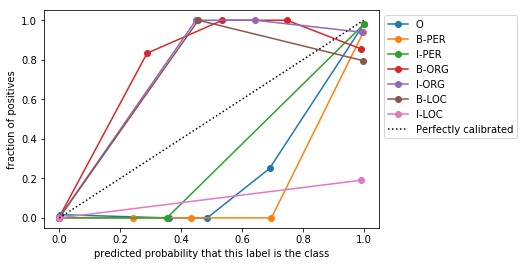

In [31]:
n_bins = 5
for label_for_calibration in bert.label_list:
    if label_for_calibration[2:]=='MISC':
        continue
    index = bert.label_list.index(label_for_calibration)
    probs = output_probabilities[:,index]
    counter = 0
    for val in probs:
        if val > 0.01 and val < 0.99:
            counter += 1
    print(f'Percent of probability for {label_for_calibration}',
          'in range 0.01 to 0.99 is {:0.3} %.'.format(100*counter/len(probs)))
    true_bin = [int(tok==label_for_calibration) for tok in categories_flattened]
    prob_true, prob_pred = calibration_curve(true_bin, probs, n_bins=n_bins)
    print(f'Amount of samples in each bin for {label_for_calibration}:', bin_total(true_bin, probs, n_bins=n_bins))
    plt.plot(prob_pred, prob_true, label=label_for_calibration, marker='o')
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.ylabel('fraction of positives')
plt.xlabel('predicted probability that this label is the class')
plt.show()

**Explanation of graph above**

0.2 on the x-axis means that the model predicted with a probability of 0.2, that a given class, for instance B-PER, was the correct one. If the model was perfectly calibrated, 20 % of all the B-PER predictions in the same 'bin' as 0.2, would be a correct classification, that is, truely a B-PER word. The y-axis represents this percentage. In the plot above, the value is 0 %, so none of the B-PER words that had a probability of around 0.2 were actually a true choice.

There are very few predictions that have a probability between 1 % and 99 %.

### Flair

In [32]:
flair_labels = flair.tag_dictionary.get_items()
flair_output_probabilities = []
for s in flair_sentences:
    for word in range(len(s)):
        probs = []
        for tok in s.tokens[word].tags_proba_dist['ner']:
            probs.append(tok.score)
        flair_output_probabilities.append(probs)
flair_output_probabilities = np.array(flair_output_probabilities)

In [33]:
print(flair_labels)

['<unk>', 'O', 'B-ORG', 'B-PER', 'I-PER', 'B-LOC', 'I-ORG', 'I-LOC', '<START>', '<STOP>']


Percent of probability for O in range 0.01 to 0.99 is 5.11 %.
Amount of samples in each bin for O: [ 547   26   62   43 9345    0]
Percent of probability for B-ORG in range 0.01 to 0.99 is 4.01 %.
Amount of samples in each bin for B-ORG: [9842   92   27   17   45    0]
Percent of probability for B-PER in range 0.01 to 0.99 is 2.68 %.
Amount of samples in each bin for B-PER: [9817   24   11    9  162    0]
Percent of probability for I-PER in range 0.01 to 0.99 is 0.519 %.
Amount of samples in each bin for I-PER: [9880    0    1    4  138    0]
Percent of probability for B-LOC in range 0.01 to 0.99 is 2.98 %.
Amount of samples in each bin for B-LOC: [9879   45   11    8   80    0]
Percent of probability for I-ORG in range 0.01 to 0.99 is 1.1 %.
Amount of samples in each bin for I-ORG: [9969    8    7   15   24    0]
Percent of probability for I-LOC in range 0.01 to 0.99 is 1.13 %.
Amount of samples in each bin for I-LOC: [10008    11     2     0     2     0]


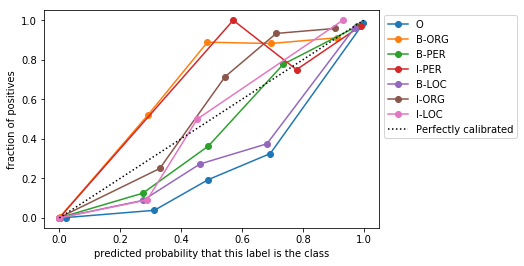

In [34]:
n_bins = 5
for label_for_calibration in flair_labels:
    if label_for_calibration=='<unk>' or label_for_calibration=='<START>' or label_for_calibration=='<STOP>':
        continue
    index = flair_labels.index(label_for_calibration)
    probs = flair_output_probabilities[:,index]
    counter = 0
    for val in probs:
        if val > 0.01 and val < 0.99:
            counter += 1
    print(f'Percent of probability for {label_for_calibration}',
          'in range 0.01 to 0.99 is {:0.3} %.'.format(100*counter/len(probs)))
    true_bin = [int(tok==label_for_calibration) for tok in categories_flattened]
    prob_true, prob_pred = calibration_curve(true_bin, probs, n_bins=n_bins)
    print(f'Amount of samples in each bin for {label_for_calibration}:', bin_total(true_bin, probs, n_bins=n_bins))
    plt.plot(prob_pred, prob_true, label=label_for_calibration, marker='o')
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.ylabel('fraction of positives')
plt.xlabel('predicted probability that this label is the class')
plt.show()

More distributed class probabilities in the flair model gives a more informative calibration plot. As seen in the examples above, the flair model is often really close to predicting the correct tag.

TODO: Use the Platt Calibration Method in https://www.cs.cornell.edu/~alexn/papers/calibration.icml05.crc.rev3.pdf to find an A and a B for each label, and then apply this on the test set.

In [123]:
calibration_constants = {}

In [46]:
train_sentences, train_categories = train
train_categories_flattened = [item for sublist in train_categories for item in sublist]

In [106]:
def get_train_flair_sentences():
    train_flair_sentences = []
    for sentence in train_sentences:
        flair_sentence = Sentence()
        for token in sentence:
            flair_sentence.add_token(Token(token))
        train_flair_sentences.append(flair_sentence)
    flair.predict(train_flair_sentences, all_tag_prob=True)
    return train_flair_sentences
train_flair_sentences = get_train_flair_sentences()

In [68]:
def get_op(flair_sentences):
    labels = flair.tag_dictionary.get_items()
    output_probabilities = []
    for s in flair_sentences:
        for word in range(len(s)):
            probs = []
            for tok in s.tokens[word].tags_proba_dist['ner']:
                probs.append(tok.score)
            output_probabilities.append(probs)
    return np.array(output_probabilities)

def get_y(label):
    y_original = [tok==label for tok in train_categories_flattened]
    N_plus = sum(y_original)
    N_minus = len(y_original) - N_plus

    y_plus = (N_plus + 1)/(N_plus + 2)
    y_minus = 1/(N_minus + 2)
    
    y = np.zeros(len(y_original))
    for i in range(len(y_original)):
        y[i] = y_plus if y_original[i] else y_minus
        
    return y

def get_f(label):
    output_probabilities = get_op(train_flair_sentences)
    flair_labels = flair.tag_dictionary.get_items()
    return output_probabilities[:, flair_labels.index(label)]

def get_p(f, A, B):
    return 1/(1+np.exp(A*f+B))

def get_loglike(f, p):
    return -np.sum(np.multiply(y, np.log(p)) + np.multiply((1-y),np.log(1-p)))

#### Manual grid search to find constants A and B

In [168]:
def manual_grid_search(lab, As, Bs):
    y = get_y(lab)
    f = get_f(lab)
    
    lowest_loglike = 100000
    for A in As:
        for B in Bs:
            p = get_p(f, A, B)
            loglike = get_loglike(f, p)
            if loglike < lowest_loglike:
                bestAB = (A, B)
                lowest_loglike = loglike
    print(bestAB, lowest_loglike)
    calibration_constants[lab] = bestAB

In [175]:
#As = np.arange(-40, -10, 0.1)
#Bs = np.arange(5, 10, 0.1)

As = np.arange(-22.81, -22.79, 0.001)
Bs = np.arange(6.99, 7.01, 0.001)

lab = 'I-LOC'

#manual_grid_search(lab, As, Bs)

#### Get resulting constant values

In [183]:
# get calibration constants
import pickle
with open(f'calibration_constants.dict', 'rb') as calibration_constants_file:
    calibration_constants = pickle.load(calibration_constants_file)

print(calibration_constants)

{'B-ORG': (-12.766, 6.224), 'O': (-11.445, 7.295), 'I-ORG': (-10.537, 6.774), 'B-PER': (-12.866, 7.593), 'I-PER': (-13.636, 8.81), 'B-LOC': (-13.606, 6.49), 'I-LOC': (-22.791, 6.99)}


In [128]:
p = get_p(f, A, B)
p

array([0.00197743, 0.00197754, 0.00197739, ..., 0.00197739, 0.00197968,
       0.00197747])

#### Use constant values on test set to introduce a new set of predictions

In [198]:
flair_labels

['<unk>',
 'O',
 'B-ORG',
 'B-PER',
 'I-PER',
 'B-LOC',
 'I-ORG',
 'I-LOC',
 '<START>',
 '<STOP>']

In [191]:
calibrated_output_probabilities = np.zeros(flair_output_probabilities.shape)

for lab in flair_labels:
    if lab=='<unk>' or lab=='<START>' or lab=='<STOP>':
        continue
    index = flair_labels.index(lab)
    
    f = flair_output_probabilities[:, index]
    A, B = calibration_constants[lab]
    
    #p = get_p(f, A, B)
    
    calibrated_output_probabilities[:,index] = get_p(f, A, B)

In [263]:
for i in range(len(calibrated_output_probabilities)):
    calibrated_output_probabilities[i] = calibrated_output_probabilities[i]/sum(calibrated_output_probabilities[i])

In [264]:
calibrated_flair_preds_flattened = [
    flair_labels[label] for label in np.argmax(calibrated_output_probabilities, axis=1) 
]

In [301]:
calibrated_output_probabilities_sentencediv = []
calibrated_flair_preds = []
how_far = 0
for i in range(len(sentences)):
    calibrated_flair_preds.append(calibrated_flair_preds_flattened[how_far:how_far+len(sentences[i])])
    calibrated_output_probabilities_sentencediv.append(
        calibrated_output_probabilities[how_far:how_far+len(sentences[i])])
    how_far += len(sentences[i])
calibrated_output_probabilities_sentencediv = np.array(calibrated_output_probabilities_sentencediv)

#### Look at where the model did changes to the output

In [265]:
def get_accuracy(preds_flattened, targets_flattened):
    correct = 0
    for i in range(len(preds_flattened)):
        correct += (preds_flattened[i]==targets_flattened[i])
    return correct/len(preds_flattened)

def get_percent_of_non_O_preds(preds_flattened, targets_flattened):
    correct = 0
    for i in range(len(preds_flattened)):
        correct += (preds_flattened[i]!='O')
    return correct/len(preds_flattened)

In [266]:
changes = 0
positive_changes = 0
negative_changes = 0
print('calibrated - flair - cat_nomisc - cat - word')
for i in range(len(flair_preds_flattened)):
    if calibrated_flair_preds_flattened[i]!=flair_preds_flattened[i]:
        print(calibrated_flair_preds_flattened[i], 
              flair_preds_flattened[i], 
              categories_nomisc_flattened[i],
              categories_flattened[i],
              sentences_flattened[i-1], "'",sentences_flattened[i],"'", sentences_flattened[i+1]
             )
        
        changes += 1
        if calibrated_flair_preds_flattened[i]==categories_nomisc_flattened[i]:
            positive_changes += 1
        if flair_preds_flattened[i]==categories_nomisc_flattened[i]:
            negative_changes += 1
print('\n')
print('Changes ')
print('Number of changes:', changes)
print('Positive changes:', positive_changes)
print('Negative changes:', negative_changes)
print('Change form wrong prediction to wrong predicton:', changes-positive_changes-negative_changes)

calibrated - flair - cat_nomisc - cat - word
B-ORG O B-ORG B-ORG mener ' Socialdemokratiets ' næstformand
B-ORG O B-ORG B-ORG og ' Aldi ' finansielle
B-ORG O B-ORG B-ORG nye ' Super-Brugser ' .
B-LOC O B-ORG B-ORG præger ' Super-Brugsen ' .
B-ORG O O B-MISC , ' B-1903-Silkeborg ' ,
B-ORG O O B-MISC , ' Frem-B ' 1903
I-LOC O O O Brøndbys ' 500-kampsjubilar ' Bjarne
I-LOC O I-ORG I-ORG Frederikshavn ' politi ' ,
B-ORG O O O kulørt ' Lycra ' med
B-ORG O B-ORG B-ORG Nedslidte ' Levi's ' jeans
B-ORG O B-ORG B-ORG , ' Status ' Quo
I-LOC O I-LOC I-LOC Kolding ' arrest ' ,
B-ORG O B-ORG B-ORG triumferede ' Ariostea ' med
B-ORG O B-ORG B-ORG , ' Gatorade-Chateau-d'Ax ' ,
B-ORG O B-ORG B-ORG på ' Ask ' var
B-ORG B-PER B-ORG B-ORG både ' Ask ' og
B-ORG O B-ORG B-ORG og ' Urd ' var
I-LOC I-ORG I-ORG I-ORG Århus ' Havns ' bugserbåd
I-LOC O O O Havns ' bugserbåd ' ,
B-ORG B-PER B-ORG B-ORG Siden ' Ungbo ' for
B-ORG O B-ORG B-ORG går ' Østlandepuljen ' ind
B-ORG B-PER B-ORG B-ORG nyhedsbureau ' Tanju

In [267]:
calibrated_flair_cm_nomisc = confusion_matrix(
    categories_nomisc_flattened, calibrated_flair_preds_flattened, labels=labels_nomisc)
calibrated_flair_cm = confusion_matrix(
    categories_flattened, calibrated_flair_preds_flattened, labels=bert.label_list)

In [268]:
print_cm(calibrated_flair_cm_nomisc, labels=labels_nomisc)

     t/p      O B-PER I-PER B-ORG I-ORG B-LOC I-LOC 
        O  9362     1     0    11     2     4     3 
    B-PER     8   169     0     2     0     1     0 
    I-PER     0     0   138     0     0     0     0 
    B-ORG    45    10     0    95     0    11     0 
    I-ORG    11     0     5     1    41     0     2 
    B-LOC     9     1     0     2     1    83     0 
    I-LOC     1     0     0     0     0     0     4 


In [269]:
print_cm(calibrated_flair_cm, labels=bert.label_list)

      t/p       O B-MISC I-MISC  B-PER  I-PER  B-ORG  I-ORG  B-LOC  I-LOC 
         O   9218      0      0      0      0      1      2      0      3 
    B-MISC    107      0      0      0      0     10      0      4      0 
    I-MISC     37      0      0      1      0      0      0      0      0 
     B-PER      8      0      0    169      0      2      0      1      0 
     I-PER      0      0      0      0    138      0      0      0      0 
     B-ORG     45      0      0     10      0     95      0     11      0 
     I-ORG     11      0      0      0      5      1     41      0      2 
     B-LOC      9      0      0      1      0      2      1     83      0 
     I-LOC      1      0      0      0      0      0      0      0      4 


In [270]:
calibrated_flair_preds_noIB_flattened = deepcopy(calibrated_flair_preds_flattened)

for i, token in enumerate(calibrated_flair_preds_noIB_flattened):
    if token!='O':
        calibrated_flair_preds_noIB_flattened[i]=token[2:]

labels_noIB = ['O', 'PER', 'ORG', 'LOC']

calibrated_flair_cm_noIB = confusion_matrix(
    categories_nomisc_noIB_flattened, calibrated_flair_preds_noIB_flattened, labels=labels_noIB)

In [271]:
print_cm(calibrated_flair_cm_noIB, labels=labels_noIB)

     t/p      O   PER   ORG   LOC 
        O  9362     1    13     7 
      PER     8   307     2     1 
      ORG    56    15   137    13 
      LOC    10     1     3    87 


In [272]:
print_cm(flair_cm, labels=bert.label_list)

      t/p       O B-MISC I-MISC  B-PER  I-PER  B-ORG  I-ORG  B-LOC  I-LOC 
         O   9222      0      0      0      0      0      2      0      0 
    B-MISC    112      0      0      0      0      5      0      4      0 
    I-MISC     37      0      0      1      0      0      0      0      0 
     B-PER      8      0      0    170      0      1      0      1      0 
     I-PER      0      0      0      0    138      0      0      0      0 
     B-ORG     59      0      0     13      0     81      0      8      0 
     I-ORG     12      0      0      0      5      1     42      0      0 
     B-LOC     10      0      0      1      0      2      1     82      0 
     I-LOC      2      0      0      0      0      0      1      0      2 


In [273]:
print_cm(flair_cm_nomisc, labels=labels_nomisc)

     t/p      O B-PER I-PER B-ORG I-ORG B-LOC I-LOC 
        O  9371     1     0     5     2     4     0 
    B-PER     8   170     0     1     0     1     0 
    I-PER     0     0   138     0     0     0     0 
    B-ORG    59    13     0    81     0     8     0 
    I-ORG    12     0     5     1    42     0     0 
    B-LOC    10     1     0     2     1    82     0 
    I-LOC     2     0     0     0     1     0     2 


In [274]:
print(classification_report(categories_nomisc_flattened, calibrated_flair_preds_flattened, labels=labels_nomisc))

              precision    recall  f1-score   support

           O       0.99      1.00      0.99      9383
       B-PER       0.93      0.94      0.94       180
       I-PER       0.97      1.00      0.98       138
       B-ORG       0.86      0.59      0.70       161
       I-ORG       0.93      0.68      0.79        60
       B-LOC       0.84      0.86      0.85        96
       I-LOC       0.44      0.80      0.57         5

    accuracy                           0.99     10023
   macro avg       0.85      0.84      0.83     10023
weighted avg       0.99      0.99      0.99     10023



In [275]:
# weighted average without 'O'
print('precision:', np.sum(np.array([0.93*180, 0.97*138, 0.86*161, 0.93*60, 0.84*96, 0.44*5])/(10023-9383)))
print('recall:', np.sum(np.array([0.94*180, 1.00*138, 0.59*161, 0.68*60, 0.86*96, 0.8*5])/(10023-9383)))
print('f1:', np.sum(np.array([0.94*180, 0.98*138, 0.70*161, 0.79*60, 0.85*96, 0.57*5])/(10023-9383)))
print('accuracy:', get_accuracy(calibrated_flair_preds_flattened, categories_nomisc_flattened))
print('non O predictions percentage:', get_percent_of_non_O_preds(
    calibrated_flair_preds_flattened, categories_nomisc_flattened))

precision: 0.9036875
recall: 0.8274218749999999
f1: 0.857796875
accuracy: 0.986930060860022
non O predictions percentage: 0.058565299810436


In [276]:
print(classification_report(categories_nomisc_flattened, flair_preds_flattened, labels=labels_nomisc))

              precision    recall  f1-score   support

           O       0.99      1.00      0.99      9383
       B-PER       0.92      0.94      0.93       180
       I-PER       0.97      1.00      0.98       138
       B-ORG       0.90      0.50      0.65       161
       I-ORG       0.91      0.70      0.79        60
       B-LOC       0.86      0.85      0.86        96
       I-LOC       1.00      0.40      0.57         5

    accuracy                           0.99     10023
   macro avg       0.94      0.77      0.83     10023
weighted avg       0.99      0.99      0.98     10023



In [277]:
# weighted average without 'O'
print('precision:', np.sum(np.array([0.92*180, 0.97*138, 0.90*161, 0.91*60, 0.86*96, 1.00*5])/(10023-9383)))
print('recall:', np.sum(np.array([0.94*180, 1.00*138, 0.50*161, 0.70*60, 0.85*96, 0.4*5])/(10023-9383)))
print('f1:', np.sum(np.array([0.93*180, 0.98*138, 0.65*161, 0.79*60, 0.86*96, 0.57*5])/(10023-9383)))
print('accuracy:', get_accuracy(flair_preds_flattened, categories_nomisc_flattened))
print('non O predictions percentage:', get_percent_of_non_O_preds(
    flair_preds_flattened, categories_nomisc_flattened))

precision: 0.9164375
recall: 0.80203125
f1: 0.84390625
accuracy: 0.9863314376933054
non O predictions percentage: 0.05597126608799761


In [278]:
print(classification_report(categories_nomisc_flattened, bert_preds_flattened, labels=labels_nomisc))

              precision    recall  f1-score   support

           O       0.99      1.00      1.00      9383
       B-PER       0.93      0.93      0.93       180
       I-PER       0.98      1.00      0.99       138
       B-ORG       0.86      0.66      0.75       161
       I-ORG       0.94      0.55      0.69        60
       B-LOC       0.80      0.90      0.84        96
       I-LOC       0.19      0.80      0.31         5

    accuracy                           0.99     10023
   macro avg       0.81      0.83      0.79     10023
weighted avg       0.99      0.99      0.99     10023



In [279]:
# weighted average without 'O'
print('precision:', np.sum(np.array([0.93*180, 0.98*138, 0.86*161, 0.94*60, 0.80*96, 0.19*5])/(10023-9383)))
print('recall:', np.sum(np.array([0.93*180, 1.00*138, 0.66*161, 0.55*60, 0.90*96, 0.80*5])/(10023-9383)))
print('f1:', np.sum(np.array([0.93*180, 0.99*138, 0.75*161, 0.69*60, 0.84*96, 0.31*5])/(10023-9383)))
print('accuracy:', get_accuracy(bert_preds_flattened, categories_nomisc_flattened))
print('non O predictions percentage:', get_percent_of_non_O_preds(
    bert_preds_flattened, categories_nomisc_flattened))

precision: 0.898828125
recall: 0.83603125
f1: 0.8568125000000001
accuracy: 0.9873291429711664
non O predictions percentage: 0.06076025142173002


### Calibration plot for calibrated flair

Percent of probability for O  in range 0.01 to 0.99 is 1.61 %.
Amount of samples in each bin for O: [ 566   21   27   17 9392    0]
Percent of probability for B-ORG  in range 0.01 to 0.99 is 1.84 %.
Amount of samples in each bin for B-ORG: [9877   30   21   17   78    0]
Percent of probability for B-PER  in range 0.01 to 0.99 is 0.649 %.
Amount of samples in each bin for B-PER: [9832   10    4    4  173    0]
Percent of probability for I-PER  in range 0.01 to 0.99 is 0.0698 %.
Amount of samples in each bin for I-PER: [9880    0    0    1  142    0]
Percent of probability for B-LOC  in range 0.01 to 0.99 is 1.25 %.
Amount of samples in each bin for B-LOC: [9900   20    6    3   94    0]
Percent of probability for I-ORG  in range 0.01 to 0.99 is 0.499 %.
Amount of samples in each bin for I-ORG: [9975    2    3    5   38    0]
Percent of probability for I-LOC  in range 0.01 to 0.99 is 0.399 %.
Amount of samples in each bin for I-LOC: [10009     4     2     2     6     0]


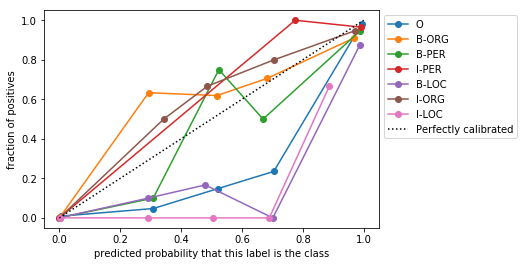

In [280]:
n_bins = 5
for lab in flair_labels:
    if lab=='<unk>' or lab=='<START>' or lab=='<STOP>':
        continue
    index = flair_labels.index(lab)
    probs = calibrated_output_probabilities[:,index]
    counter = 0
    for val in probs:
        if val > 0.01 and val < 0.99:
            counter += 1
    print(f'Percent of probability for {lab}',' in range 0.01 to 0.99 is {:0.3} %.'.format(100*counter/len(probs)))
    true_bin = [int(tok==lab) for tok in categories_flattened]
    prob_true, prob_pred = calibration_curve(true_bin, probs, n_bins=n_bins)
    print(f'Amount of samples in each bin for {lab}:', bin_total(true_bin, probs, n_bins=n_bins))
    plt.plot(prob_pred, prob_true, label=lab, marker='o')
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.ylabel('fraction of positives')
plt.xlabel('predicted probability that this label is the class')
plt.show()

### Choose ten sentences and compare calibrated flair, flair and BERT predictions

Sentence: ['Uden', 'dog', 'at', 'opnå', 'meget', 'mere', 'end', 'æren', ',', 'fordi', 'DM-guldet', 'mod', 'sædvane', 'ikke', 'vil', 'give', 'adgang', 'til', 'Europa', 'Cup', 'turneringerne', '.']
Targets: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'O', 'O']


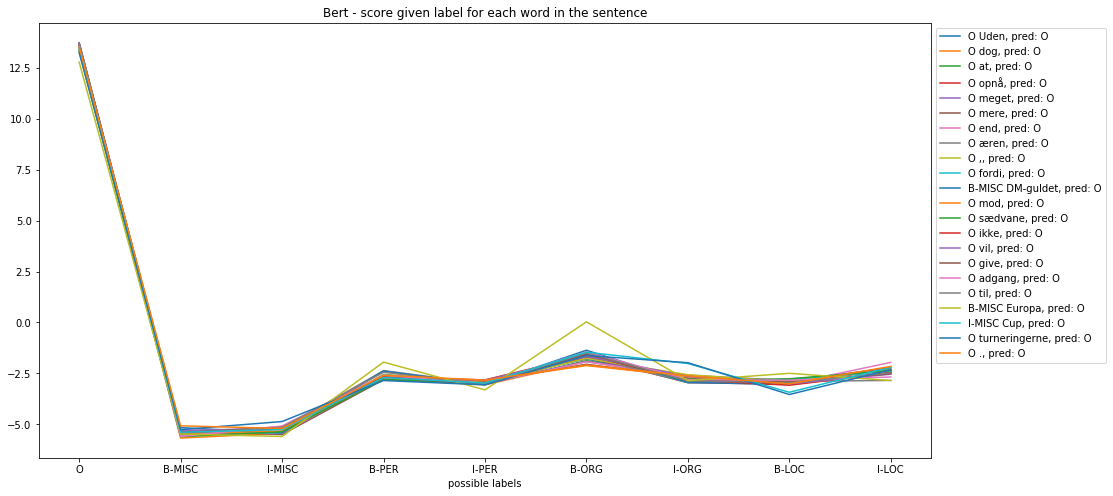

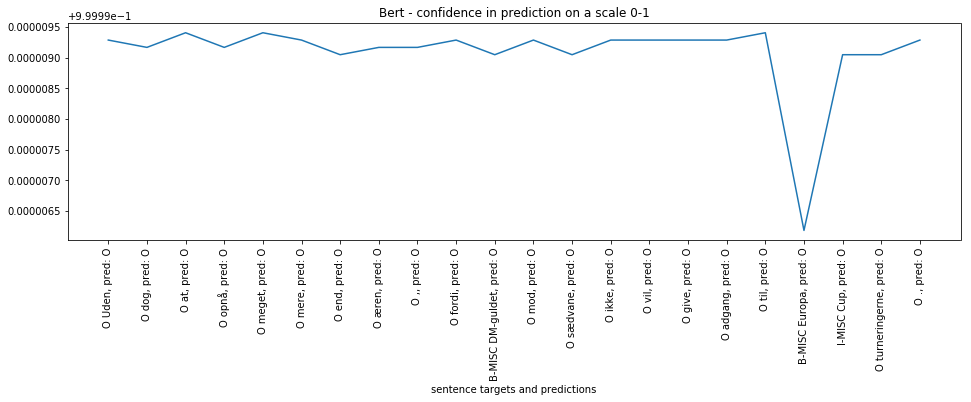

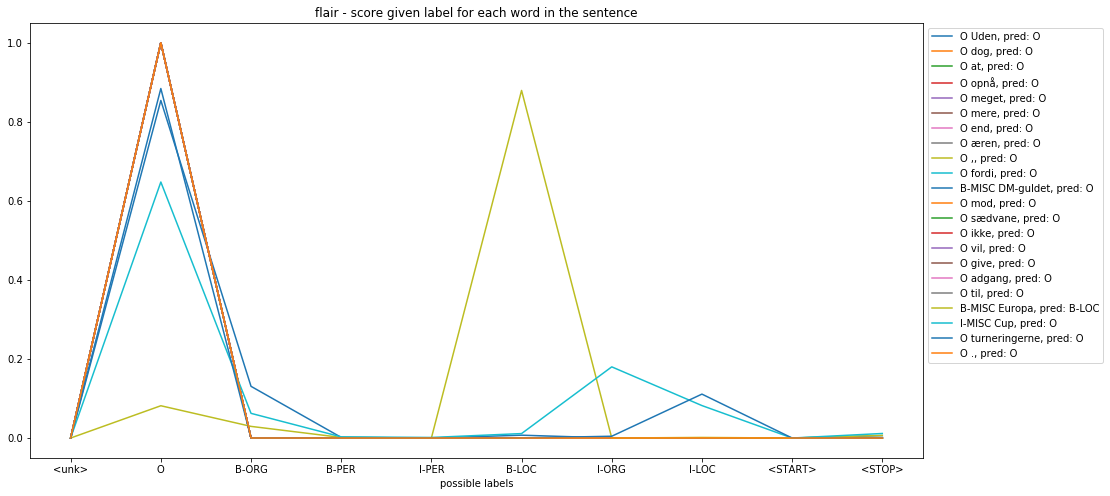

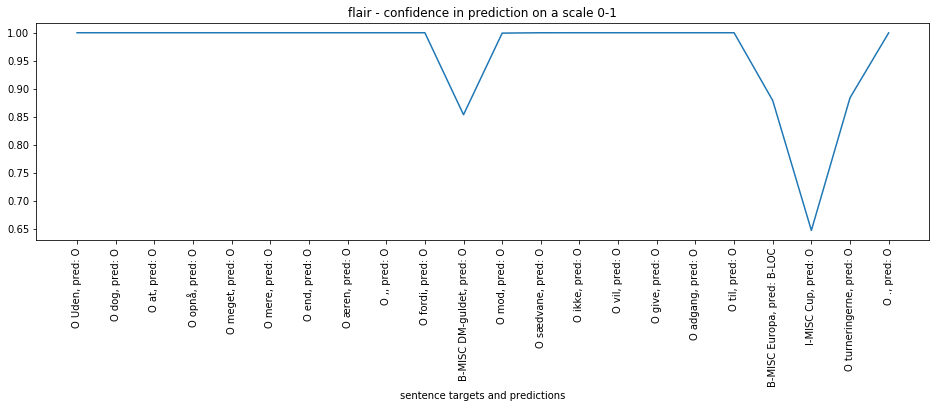

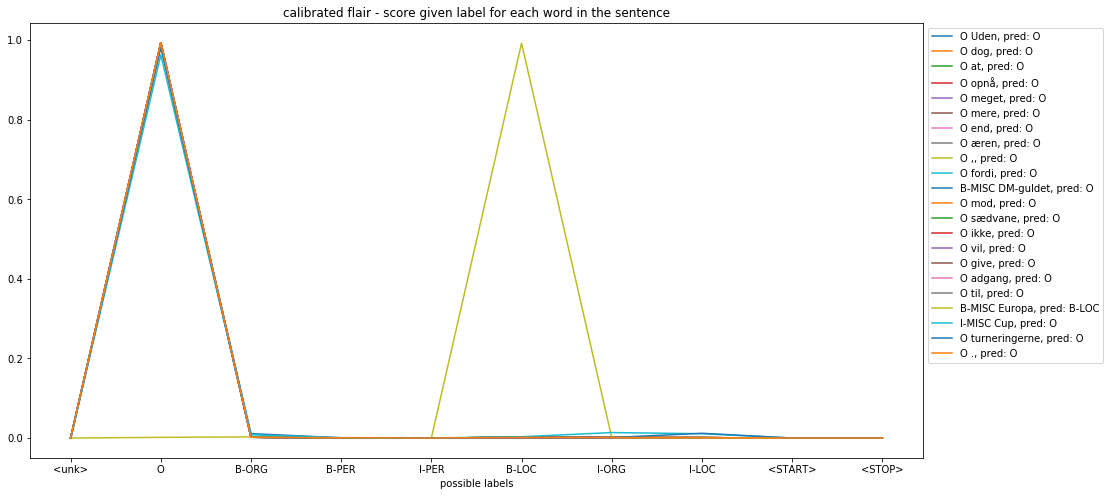

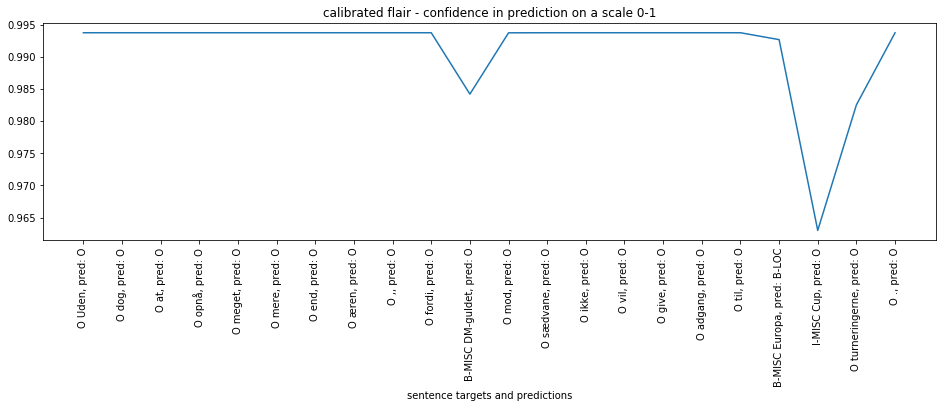

Sentence: ['Uden', 'dog', 'at', 'opnå', 'meget', 'mere', 'end', 'æren', ',', 'fordi', 'DM-guldet', 'mod', 'sædvane', 'ikke', 'vil', 'give', 'adgang', 'til', 'Europa', 'Cup', 'turneringerne', '.']
Targets: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'O', 'O']
Bert predictions: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Flair predictions: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O']
Calibrated flair predictions: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O']


In [324]:
index = 86

# interesting sentences:
# 11, 15, 32, 46, 55, 63, 65, 71, 82, 86

calibrated_model_info = {}
calibrated_model_info['index'] = index
calibrated_model_info['predictions'] = calibrated_flair_preds[index]
calibrated_model_info['output_probabilities'] = calibrated_output_probabilities_sentencediv[index]

bert_info, flair_info = sentence_prediction_analysis(
    sentences[index], categories[index], True, calibrated_model_info)